# Portfolio optimizálás

In [216]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import scipy.optimize as sc

In [217]:
def getData(stocks, start, end):
    stockdata= yf.download(stocks, start=start, end=end, adjusted=True, progress=False)
    stockdata=stockdata['Adj Close']
    
    # Simple returns
    returns         = stockdata.pct_change()
    meanReturns     = returns.mean()
    covMatrix       = returns.cov()
    
    #log returns
    returns_log     = np.log(stockdata/stockdata.shift(1))
    meanReturns_log = returns_log.mean()
    covMatrix_log   = returns_log.cov()

    return meanReturns, covMatrix, meanReturns_log,  covMatrix_log, stockdata

In [218]:
def portfolioPerformance(weights, meanReturns, covMatrix):
    returns = np.sum(meanReturns*weights)*252
    std = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights))) * np.sqrt(252)
    return returns, std

In [242]:
assets = ['OTP.BD', 'ZWACK.BD', 'BIF.BD', 'MOL.BD', '4IG.BD', 
          'OPUS.BD', 'ANY.BD', 'ALTEO.BD','RABA.BD', 'AKKO.BD', 'DELTA.BD' ]
assets.sort()
weights = np.array([1/len(assets)]*len(assets))

In [243]:
endDate= dt.datetime.now()- dt.timedelta(days=1)
startDate = '2021-01-01'

meanReturns, covMatrix, meanReturns_log,  covMatrix_log, stockdata = getData(assets, startDate, endDate)
returns, std = portfolioPerformance(weights, meanReturns, covMatrix)
returns_log, std_log = portfolioPerformance(weights, meanReturns_log, covMatrix_log)

print('Átlagos (várható) hozam az időszakban')
print(meanReturns)
print('\nCovarancia mátrix')
print(covMatrix)

print('\nÁtlagos (várható) hozam az időszakban (LOG)')
print(meanReturns_log)
print('\nCovarancia mátrix (LOG)')
print(covMatrix_log)

print('\nÉvesített portfolio hozam:{:.2%} (log{:.2%})\
    \nkockázat/szórás/volatilitás:{:.2%} (log {:.2%})'.format(returns, returns_log,std, std_log))

Átlagos (várható) hozam az időszakban
4IG.BD     -0.000179
AKKO.BD     0.003869
ALTEO.BD    0.006074
ANY.BD      0.000171
BIF.BD      0.000682
DELTA.BD   -0.000033
MOL.BD     -0.000391
OPUS.BD    -0.004258
OTP.BD     -0.000677
RABA.BD    -0.004434
ZWACK.BD   -0.000053
dtype: float64

Covarancia mátrix
                4IG.BD       AKKO.BD  ALTEO.BD    ANY.BD    BIF.BD  DELTA.BD  \
4IG.BD    9.215773e-05  9.363586e-07  0.000128  0.000031  0.000024  0.000031   
AKKO.BD   9.363586e-07  5.133876e-04  0.000175  0.000043  0.000148  0.000073   
ALTEO.BD  1.281688e-04  1.748924e-04  0.001504  0.000062  0.000452  0.000264   
ANY.BD    3.098600e-05  4.319256e-05  0.000062  0.000129  0.000029  0.000007   
BIF.BD    2.360966e-05  1.480977e-04  0.000452  0.000029  0.000560 -0.000010   
DELTA.BD  3.105859e-05  7.268104e-05  0.000264  0.000007 -0.000010  0.000270   
MOL.BD    5.636893e-05 -5.346688e-05  0.000221  0.000029  0.000010  0.000115   
OPUS.BD   4.947187e-05  8.260205e-06  0.000119  0.000016 

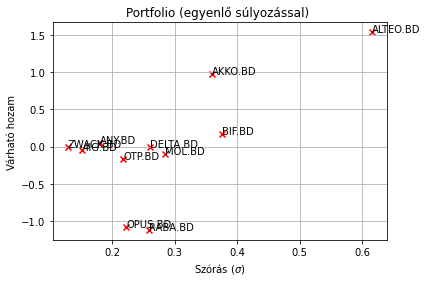

In [246]:
sigma = stockdata.pct_change().std()* np.sqrt(252)
mu = stockdata.pct_change().mean()*252
n = assets

fig, ax = plt.subplots()
ax.scatter(x=sigma, y=mu, marker='x', color='red')

for i, txt in enumerate(n):
    ax.annotate(txt, (sigma[i]+0.0002, mu[i]))
    ax.grid(True)
    
plt.title("Portfolio (egyenlő súlyozással) ")
plt.xlabel("Szórás ($\sigma$)")
cx=plt.ylabel("Várható hozam")

In [247]:
sigma

4IG.BD      0.152393
AKKO.BD     0.359686
ALTEO.BD    0.615636
ANY.BD      0.180574
BIF.BD      0.375520
DELTA.BD    0.260837
MOL.BD      0.284301
OPUS.BD     0.222788
OTP.BD      0.218379
RABA.BD     0.259526
ZWACK.BD    0.129488
dtype: float64

In [248]:
mu

4IG.BD     -0.045069
AKKO.BD     0.974963
ALTEO.BD    1.530629
ANY.BD      0.043041
BIF.BD      0.171978
DELTA.BD   -0.008367
MOL.BD     -0.098614
OPUS.BD    -1.073010
OTP.BD     -0.170530
RABA.BD    -1.117425
ZWACK.BD   -0.013247
dtype: float64

In [249]:
np.dot(sigma, mu)

0.7602470465687041

In [250]:
(0.152393*-0.045069) + (0.284301*-0.098614)+(0.218379*-0.170530) + (0.129488*-0.013247)

-0.073859757337

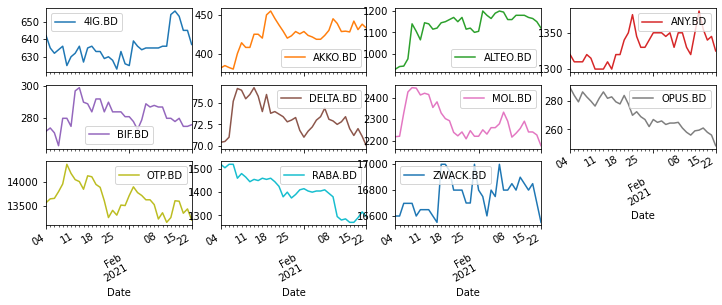

In [254]:
ax = stockdata.plot(subplots=True, layout=(4,4), figsize=(12,6))

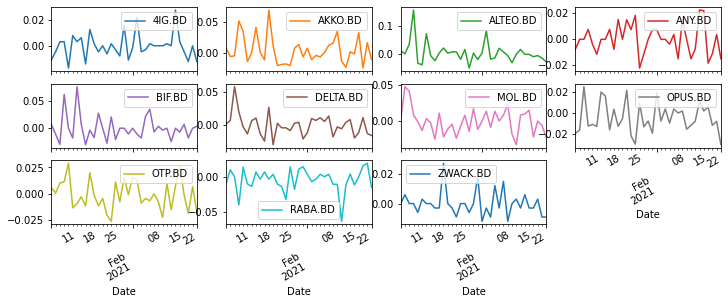

In [255]:
ax=np.log(stockdata/stockdata.shift(1)).dropna().plot(subplots=True, layout=(4,4), figsize=(12,6))

In [256]:
# optimalizálás
weights = np.array([1/len(assets)]*len(assets))
weights

array([0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909])

In [257]:
def negativeSR(weights, meanReturns, covMatrix, riskFree=0):
    pReturns, pStd = portfolioPerformance(weights, meanReturns, covMatrix)
    return -(pReturns -riskFree)/pStd

In [258]:
def maxSR(meanReturns, covMatrix, riskFree=0, constrainSet=(0,1)):
    'minimize the negative sharp ratio by altering the weights of the portfolio'
    numAssets = len(meanReturns)
    args=(meanReturns, covMatrix, riskFree)
    constraints=(
        {'type':'eq',
        'fun': lambda x:np.sum(x)-1})

    bound = constrainSet
    bounds = tuple(bound for assets in range(numAssets))

    result=sc.minimize(negativeSR, 
        numAssets*[1./numAssets], 
        args=args,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints)

    return result

In [259]:
result = maxSR(meanReturns, covMatrix)
result

     fun: -3.360585034963979
     jac: array([ 4.41659182e-01,  5.11229038e-04, -9.96440649e-04,  2.24891901e-01,
        1.27754182e+00,  9.95455235e-01,  5.65368235e-01,  3.42349958e+00,
        1.13137484e+00,  2.87863618e+00,  2.94586182e-01])
 message: 'Optimization terminated successfully'
    nfev: 74
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([2.30084208e-17, 6.60934515e-01, 3.39065485e-01, 3.36046331e-16,
       4.40281410e-16, 0.00000000e+00, 4.63657102e-16, 4.94573101e-17,
       0.00000000e+00, 1.00204217e-16, 2.47018177e-16])

In [260]:
def portfolioVariance(weights, meanReturns, covMatrix):
    return portfolioPerformance(weights, meanReturns, covMatrix)[1]

def minimizeVariance(meanReturns, covMatrix, riskFree=0, constrainSet=(0,1)):
    numAssets = len(meanReturns)
    args=(meanReturns, covMatrix )
    constraints=(
        {'type':'eq',
        'fun': lambda x:np.sum(x)-1})

    bound = constrainSet
    bounds = tuple(bound for assets in range(numAssets))

    result=sc.minimize(portfolioVariance, 
        numAssets*[1./numAssets], 
        args=args,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints)

    return result

minVarResult = minimizeVariance(meanReturns, covMatrix)
minVar, minVarWeights = minVarResult['fun'], minVarResult['x']
print('\n Min Variance')
print(minVar, minVarWeights )


 Min Variance
0.08448402253283757 [1.55680402e-01 0.00000000e+00 2.39066579e-17 1.55424411e-01
 5.64063613e-02 8.87962333e-03 3.09539720e-17 5.75221527e-02
 7.59885649e-02 9.52352966e-02 3.94863188e-01]


In [261]:
def calculatedResults(meanReturns, covMatrix, riskFree=0, constrainSet=(0,1)):
    # max sharpe ratio
    maxSR_portfolio = maxSR(meanReturns, covMatrix)
    maxSR_returns, maxSR_std = portfolioPerformance(maxSR_portfolio['x'], meanReturns, covMatrix)
    maxSR_allocation= pd.DataFrame(maxSR_portfolio['x'], index=meanReturns.index, columns=['allocation'])

    # min volatility portfolio
    minVol_portfolio = minimizeVariance(meanReturns, covMatrix)
    minVol_returns, minVol_std = portfolioPerformance(minVol_portfolio['x'], meanReturns, covMatrix)
    minVol_allocation= pd.DataFrame(minVol_portfolio['x'], index=meanReturns.index, columns=['allocation'])

    return maxSR_returns, maxSR_std, maxSR_allocation, minVol_returns, minVol_std, minVol_allocation

In [262]:
maxSR_returns, maxSR_std, maxSR_allocation, minVol_returns, minVol_std, minVol_allocation = calculatedResults(meanReturns, covMatrix)
print('Max Sharpe Ratio portfolio')
print('Returns:\t{:.2%} \nVolatility:\t{:.2%} \nWeights:{}'.format(maxSR_returns, maxSR_std, maxSR_allocation.round(6)))
print('\n')
print('Min Volatility portfolio')
print('Returns:\t{:.2%} \nVolatility:\t{:.2%} \nWeights:{}'.format(minVol_returns, minVol_std, minVol_allocation.round(6)))

Max Sharpe Ratio portfolio
Returns:	116.34% 
Volatility:	34.62% 
Weights:          allocation
4IG.BD      0.000000
AKKO.BD     0.660935
ALTEO.BD    0.339065
ANY.BD      0.000000
BIF.BD      0.000000
DELTA.BD    0.000000
MOL.BD      0.000000
OPUS.BD     0.000000
OTP.BD      0.000000
RABA.BD     0.000000
ZWACK.BD    0.000000


Min Volatility portfolio
Returns:	-17.70% 
Volatility:	8.45% 
Weights:          allocation
4IG.BD      0.155680
AKKO.BD     0.000000
ALTEO.BD    0.000000
ANY.BD      0.155424
BIF.BD      0.056406
DELTA.BD    0.008880
MOL.BD      0.000000
OPUS.BD     0.057522
OTP.BD      0.075989
RABA.BD     0.095235
ZWACK.BD    0.394863


In [263]:
def portfolioReturns(weights, meanReturns, covMatrix):
    return portfolioPerformance(weights, meanReturns, covMatrix)[0]

# Efficient frontier
def efficientOpt(meanReturns, covMatrix, returnTarget, constrainSet=(0,1)):
    numAssets = len(meanReturns)
    args=(meanReturns, covMatrix)
    
    constraints=({'type':'eq','fun': lambda x: portfolioReturns(x, meanReturns, covMatrix)-returnTarget},
                 {'type':'eq','fun': lambda x: np.sum(x)-1})

    bound=constrainSet
    bounds = tuple(bound for asset in range(numAssets)) 

    effOpt = sc.minimize(portfolioVariance, numAssets*[1/numAssets], 
        args=args, 
        constraints = constraints, 
        bounds= bounds, 
        method= 'SLSQP')

    return effOpt


In [264]:
efficientOpt(meanReturns, covMatrix, 0.1)

     fun: 0.09990326215003198
     jac: array([0.08295895, 0.20608163, 0.27310846, 0.09267888, 0.10864949,
       0.10073335, 0.07612406, 0.03843577, 0.06706697, 0.00823934,
       0.08595736])
 message: 'Optimization terminated successfully'
    nfev: 109
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([2.00485978e-01, 9.39910660e-02, 1.37372537e-02, 1.70655488e-01,
       2.87621964e-02, 0.00000000e+00, 3.40573658e-02, 1.86482774e-17,
       4.12673125e-02, 0.00000000e+00, 4.17043340e-01])

In [245]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Bar(y=[2, 3, 1]))
fig.write_html('first_figure.html', auto_open=True)